In [374]:
ignore_retweets = True
check_covid_words = True



In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import datetime
import glob


import nltk
import string, re

from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud, STOPWORDS

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wl = nltk.stem.WordNetLemmatizer()

In [376]:
df = pd.read_csv('data/religious_twitter_df.csv', index_col=False, low_memory=False)
df.head(2)

,created_at,original_text,clean_text,sentiment,location,final_text,religious_text,is_religious_tweet,polarity,subjectivity,date,final_text_merge,covid_text,is_covid_tweet
0,Sun May 24 23:59:59 +0000 2020,RT @morethanmySLE: Dr. Birx leaves the America...,RT morethanmySLE Dr. Birx leaves American peop...,"Sentiment(polarity=0.0, subjectivity=0.0)",NaN,rt leaves dr people covid19 answers birx moret...,NaN,no,0.000000,0.000000,2020-05-24,rtleavesdrpeoplecovid19answersbirxmorethanmysl...,covid,yes
1,Sun May 10 05:19:14 +0000 2020,RT @ABsteward: NEW @JAMA_current\nInterpreting...,RT ABsteward NEW JAMA_current Interpreting Dia...,"Sentiment(polarity=0.13636363636363635, subjec...","ÜT: -2.149611,106.131112",rt tcoys7panhsp1 new diagnostic tests interpre...,NaN,no,0.136364,0.454545,2020-05-10,rttcoys7panhsp1newdiagnostictestsinterpretings...,covid,yes


In [377]:
df.shape

(1292097, 14)

In [378]:
if ignore_retweets:
    df = df[~df['original_text'].str.startswith('RT @')]

In [379]:
df.shape

(274712, 14)

In [380]:
# def parse_sentiment(sentiment, pattern):
#     result = re.search(pattern, sentiment)
#     return float(result.group(1))

# df['polarity'] = df['sentiment'].apply(lambda x: parse_sentiment(x, 'Sentiment\(polarity=(.*), subjectivity=.*'))
# df['subjectivity'] = df['sentiment'].apply(lambda x: parse_sentiment(x, '.*subjectivity=(.*)\)'))
# df.head(2)


# df['date'] = df['created_at'].apply(lambda x: pd.to_datetime(x[4:10]+' 2020', format="%b %d %Y"))
# df.head(2)

In [381]:
# non_religion_df=df.loc[df['religious_text'].isnull()]
# religion_df=df.loc[~df['religious_text'].isnull()]



religion_df=df.loc[df.is_religious_tweet=='yes']
non_religion_df=df.loc[df.is_religious_tweet=='no']

print(df.shape, religion_df.shape, non_religion_df.shape)

(274712, 14) (43360, 14) (231352, 14)


In [382]:
if check_covid_words:
    religion_df=df[(df.is_covid_tweet=='yes') & (df.is_religious_tweet=='yes')]
    non_religion_df=df[~((df.is_covid_tweet=='yes') & (df.is_religious_tweet=='yes'))]

    print(df.shape, religion_df.shape, non_religion_df.shape)
    
    df.loc[(df.is_covid_tweet=='yes') & (df.is_religious_tweet=='yes'), 'is_religious_covid_tweet'] = 'yes'
    df.loc[~((df.is_covid_tweet=='yes') & (df.is_religious_tweet=='yes')), 'is_religious_covid_tweet'] = 'no'

(274712, 14) (25931, 14) (248781, 14)


In [383]:
print(df.shape, religion_df.shape, non_religion_df.shape)

(274712, 15) (25931, 14) (248781, 14)


In [384]:
def draw_dist_plot(df, col):
    sns.distplot(df[col])

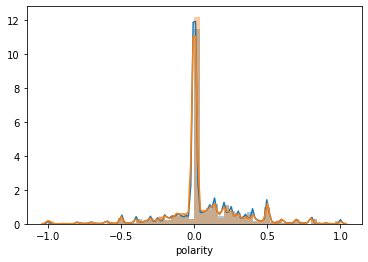

In [385]:
draw_dist_plot(non_religion_df, 'polarity')
draw_dist_plot(religion_df, 'polarity')


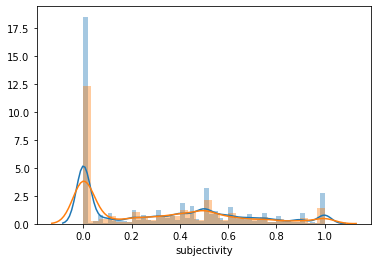

In [386]:
draw_dist_plot(non_religion_df, 'subjectivity')
draw_dist_plot(religion_df, 'subjectivity')

In [387]:
# pos_polarity = sum(list(df[df['polarity']>0]['polarity']))
# neg_polarity = sum(list(df[df['polarity']<0]['polarity']))

# print(pos_polarity, neg_polarity)


38.5109795362186 17.094151080669345 44.39486938311205


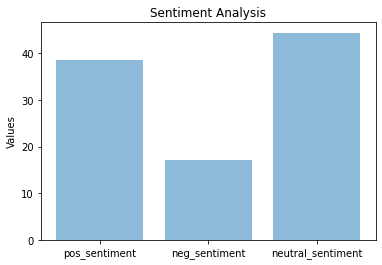

35.22810535652308 17.61598087231499 47.15591377116193


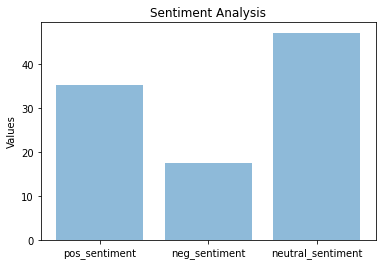

In [388]:
def get_polarity_count(df, col):
    pos_sentiment = len(df[df['polarity']>0])
    neg_sentiment = len(df[df['polarity']<0])
    neutral_sentiment = len(df[df['polarity']==0])

    total = pos_sentiment + neg_sentiment + neutral_sentiment
    
    print(100*pos_sentiment/total, 100*neg_sentiment/total, 100*neutral_sentiment/total)
#     print(pos_sentiment, neg_sentiment, neutral_sentiment)
    
    objects = ('pos_sentiment', 'neg_sentiment', 'neutral_sentiment')
    y_pos = np.arange(len(objects))
#     performance = [pos_sentiment, neg_sentiment, neutral_sentiment]
    performance = [100*pos_sentiment/total, 100*neg_sentiment/total, 100*neutral_sentiment/total]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Values')
    plt.title('Sentiment Analysis')

    plt.show()

    
get_polarity_count(non_religion_df, 'polarity')
get_polarity_count(religion_df, 'polarity') 


In [389]:
pos_religion_df = religion_df[religion_df['polarity']>0]
neg_religion_df = religion_df[religion_df['polarity']<0]
neutral_religion_df = religion_df[religion_df['polarity']==0]

In [390]:
def draw_word_cloud(col, plot_name):
    comment_words = '' 
    stopwords = set(STOPWORDS)
    
    for val in col:
        val = str(val)
        tokens = val.split() 
 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(width = 800, 
                          height = 800,
                          background_color ='white',
                          stopwords = stopwords, 
                          collocations=False,
                          min_font_size = 10).generate(comment_words) 
                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(plot_name)
    
    plt.savefig('plots/' + plot_name + '.pdf')
    
    plt.show() 
    
    


In [391]:
# draw_word_cloud(religion_df.final_text, 'religion_word_cloud.pdf')
# draw_word_cloud(non_religion_df.final_text, 'non_religion_word_cloud.pdf')

In [392]:
# draw_word_cloud(pos_religion_df.final_text, 'pos_religion_word_cloud.pdf')
# draw_word_cloud(neg_religion_df.final_text, 'neg_religion_word_cloud.pdf')
# draw_word_cloud(neutral_religion_df.final_text, 'neutral_religion_word_cloud.pdf')

In [393]:
# draw_word_cloud(religion_df.religious_text, 'religion_word_cloud')
# draw_word_cloud(pos_religion_df.religious_text, 'pos_religion_word_cloud')
# draw_word_cloud(neg_religion_df.religious_text, 'neg_religion_word_cloud')
# draw_word_cloud(neutral_religion_df.religious_text, 'neutral_religion_word_cloud')

In [394]:
df.columns

Index(['created_at', 'original_text', 'clean_text', 'sentiment', 'location',
       'final_text', 'religious_text', 'is_religious_tweet', 'polarity',
       'subjectivity', 'date', 'final_text_merge', 'covid_text',
       'is_covid_tweet', 'is_religious_covid_tweet'],
      dtype='object')

In [395]:
religion_tweet_total = df.groupby(['date', 'is_religious_tweet'])['original_text'].count()
religion_tweet_total

date        is_religious_tweet
2020-05-03  no                     2153
            yes                     361
2020-05-10  no                    93402
            yes                   16437
2020-05-17  no                    67549
            yes                   12837
2020-05-24  no                    68248
            yes                   13725
Name: original_text, dtype: int64

In [396]:
religion_tweet_percentage = religion_tweet_total.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
religion_tweet_percentage

date        is_religious_tweet
2020-05-03  no                    85.640414
            yes                   14.359586
2020-05-10  no                    85.035370
            yes                   14.964630
2020-05-17  no                    84.030801
            yes                   15.969199
2020-05-24  no                    83.256682
            yes                   16.743318
Name: original_text, dtype: float64

In [397]:
#-------------------------- ignore_retweets = True

# date        is_religious_tweet
# 2020-05-03  no                    85.640414
#             yes                   14.359586
# 2020-05-10  no                    85.035370
#             yes                   14.964630
# 2020-05-17  no                    84.030801
#             yes                   15.969199
# 2020-05-24  no                    83.256682
#             yes                   16.743318
# Name: original_text, dtype: float64

In [398]:
#-------------------------- ignore_retweets = False

# date        is_religious_tweet
# 2020-05-03  no                    84.527776
#             yes                   15.472224
# 2020-05-10  no                    79.713026
#             yes                   20.286974
# 2020-05-17  no                    83.945939
#             yes                   16.054061
# 2020-05-24  no                    80.201225
#             yes                   19.798775
# Name: original_text, dtype: float64

In [399]:
religion_covid_tweet_total = df.groupby(['date', 'is_religious_covid_tweet'])['original_text'].count()
religion_covid_tweet_percentage = religion_covid_tweet_total.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
religion_covid_tweet_percentage

date        is_religious_covid_tweet
2020-05-03  no                          91.447892
            yes                          8.552108
2020-05-10  no                          91.052358
            yes                          8.947642
2020-05-17  no                          90.206006
            yes                          9.793994
2020-05-24  no                          90.222390
            yes                          9.777610
Name: original_text, dtype: float64

In [400]:
#-------------------------- ignore_retweets = True

# date        is_religious_covid_tweet
# 2020-05-03  no                          91.447892
#             yes                          8.552108
# 2020-05-10  no                          91.052358
#             yes                          8.947642
# 2020-05-17  no                          90.206006
#             yes                          9.793994
# 2020-05-24  no                          90.222390
#             yes                          9.777610
# Name: original_text, dtype: float64

In [401]:
#-------------------------- ignore_retweets = False

# date        is_religious_covid_tweet
# 2020-05-03  no                          92.058573
#             yes                          7.941427
# 2020-05-10  no                          87.566028
#             yes                         12.433972
# 2020-05-17  no                          89.061694
#             yes                         10.938306
# 2020-05-24  no                          87.279257
#             yes                         12.720743
# Name: original_text, dtype: float64

In [402]:
covid_tweet_total = df.groupby(['date', 'is_covid_tweet'])['original_text'].count()
covid_tweet_percentage = covid_tweet_total.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
covid_tweet_percentage

date        is_covid_tweet
2020-05-03  no                30.270485
            yes               69.729515
2020-05-10  no                33.260499
            yes               66.739501
2020-05-17  no                32.564128
            yes               67.435872
2020-05-24  no                34.233223
            yes               65.766777
Name: original_text, dtype: float64

In [ ]:
#-------------------------- ignore_retweets = True

# date        is_covid_tweet
# 2020-05-03  no                30.270485
#             yes               69.729515
# 2020-05-10  no                33.260499
#             yes               66.739501
# 2020-05-17  no                32.564128
#             yes               67.435872
# 2020-05-24  no                34.233223
#             yes               65.766777
# Name: original_text, dtype: float64

In [403]:
#-------------------------- ignore_retweets = False

# date        is_covid_tweet
# 2020-05-03  no                31.928411
#             yes               68.071589
# 2020-05-10  no                34.217659
#             yes               65.782341
# 2020-05-17  no                33.924521
#             yes               66.075479
# 2020-05-24  no                29.604738
#             yes               70.395262
# Name: original_text, dtype: float64